In [76]:
import yfinance as yf
import pandas as pd
import numpy as np
import os, pdb, sys

# List of stock tickers
stocks = ['^GSPC', '^DJI', '^IXIC', '^VIX']

# Date range
start_date = '2015-01-01'
end_date = '2023-6-30'

# Download the data
data = yf.download(stocks, start=start_date, end=end_date)['Adj Close']

# Save to a single DataFrame indexed by date
df = pd.DataFrame(data)
df.to_csv('market_stocks.csv', index = None)
df.head()

[*********************100%***********************]  4 of 4 completed


,^DJI,^GSPC,^IXIC,^VIX
Date,,,,
2015-01-02,17832.990234,2058.199951,4726.810059,17.790001
2015-01-05,17501.650391,2020.579956,4652.569824,19.920000
2015-01-06,17371.640625,2002.609985,4592.740234,21.120001
2015-01-07,17584.519531,2025.900024,4650.470215,19.309999
2015-01-08,17907.869141,2062.139893,4736.189941,17.010000


In [77]:
# df = pd.read_csv('market_stocks.csv')
rt = df.pct_change().fillna(0.0).reset_index()
rt.head()

,Date,^DJI,^GSPC,^IXIC,^VIX
0,2015-01-02,0.000000,0.000000,0.000000,0.000000
1,2015-01-05,-0.018580,-0.018278,-0.015706,0.119730
2,2015-01-06,-0.007428,-0.008893,-0.012859,0.060241
3,2015-01-07,0.012254,0.011630,0.012570,-0.085701
4,2015-01-08,0.018388,0.017888,0.018432,-0.119109


In [78]:
res = {} 
cols = stocks
from gudhi import RipsComplex, SimplexTree
import matplotlib.pyplot as plt


# Create a function to compute persistence diagrams
def compute_persistence_diagrams(data):
    rips_complex = RipsComplex(points=data)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    simplex_tree.persistence()
    persistence_intervals = simplex_tree.persistence_intervals_in_dimension(1)
    return persistence_intervals

# Create a function to compute persistence entropy
def compute_persistence_entropy(diagrams):
    entropies = []
    for diagram in diagrams:
        lifetimes = diagram[:, 1] - diagram[:, 0]
        lifetimes = lifetimes[lifetimes > 0]
        if len(lifetimes) > 0:
            p = lifetimes / lifetimes.sum()
            entropy = -np.sum(p * np.log(p))
        else:
            entropy = 0
        entropies.append(entropy)
    return entropies

# Compute persistence entropy over time
entropy_values = []
w = 14
for start in range(len(rt) - w + 1):
    window_data = rt[cols].iloc[start:start + w].values
    persistence_diagrams = [compute_persistence_diagrams(window_data)]
    entropy_value = compute_persistence_entropy(persistence_diagrams)[0]
    entropy_values.append(entropy_value)
rt['pe'] = [0]*(w-1) + entropy_values
rt.head()

,Date,^DJI,^GSPC,^IXIC,^VIX,pe
0,2015-01-02,0.000000,0.000000,0.000000,0.000000,0.0
1,2015-01-05,-0.018580,-0.018278,-0.015706,0.119730,0.0
2,2015-01-06,-0.007428,-0.008893,-0.012859,0.060241,0.0
3,2015-01-07,0.012254,0.011630,0.012570,-0.085701,0.0
4,2015-01-08,0.018388,0.017888,0.018432,-0.119109,0.0


([<matplotlib.axis.XTick at 0x1ee6cfe8e90>,
 [Text(0, 0, '2015-10'),
  Text(1, 0, ''),
  Text(2, 0, ''),
  Text(3, 0, ''),
  Text(4, 0, '2015-3'),
  Text(5, 0, ''),
  Text(6, 0, ''),
  Text(7, 0, ''),
  Text(8, 0, '2015-7'),
  Text(9, 0, ''),
  Text(10, 0, ''),
  Text(11, 0, ''),
  Text(12, 0, '2016-10'),
  Text(13, 0, ''),
  Text(14, 0, ''),
  Text(15, 0, ''),
  Text(16, 0, '2016-3'),
  Text(17, 0, ''),
  Text(18, 0, ''),
  Text(19, 0, ''),
  Text(20, 0, '2016-7'),
  Text(21, 0, ''),
  Text(22, 0, ''),
  Text(23, 0, ''),
  Text(24, 0, '2017-10'),
  Text(25, 0, ''),
  Text(26, 0, ''),
  Text(27, 0, ''),
  Text(28, 0, '2017-3'),
  Text(29, 0, ''),
  Text(30, 0, ''),
  Text(31, 0, ''),
  Text(32, 0, '2017-7'),
  Text(33, 0, ''),
  Text(34, 0, ''),
  Text(35, 0, ''),
  Text(36, 0, '2018-10'),
  Text(37, 0, ''),
  Text(38, 0, ''),
  Text(39, 0, ''),
  Text(40, 0, '2018-3'),
  Text(41, 0, ''),
  Text(42, 0, ''),
  Text(43, 0, ''),
  Text(44, 0, '2018-7'),
  Text(45, 0, ''),
  Text(46, 0, ''

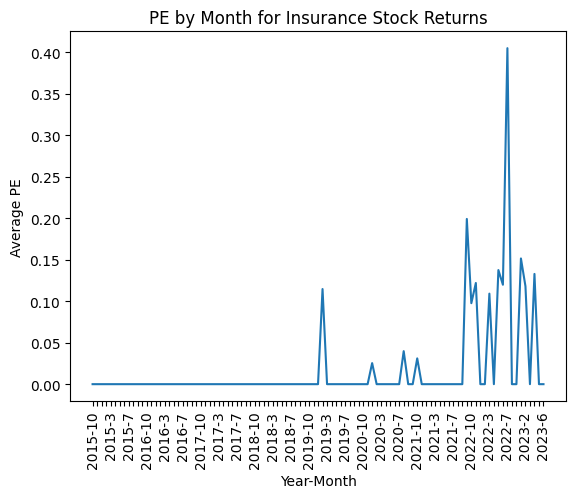

In [79]:
# Add Year-Mo for Visualization
rt['year-mo'] = [str(i.year) + '-' + str(i.month) for i in rt['Date']]
gp = rt[['year-mo', 'pe']].groupby(['year-mo']).mean().reset_index().iloc[1:].reset_index(drop = True)
plt.plot(gp.index, gp.pe, label = 'pe')
plt.title('PE by Month for Insurance Stock Returns') 
plt.xlabel('Year-Month')
plt.ylabel('Average PE')
names = [] 
ct = 0 
while len(names) < len(gp): 
    if ct % 4 == 0: 
        names.append(gp['year-mo'][ct])
    else: 
        names.append('')
    ct += 1

plt.xticks(gp.index, names, rotation = 90)

# Compare Test Performance

In [80]:
from hotelling.stats import hotelling_t2
from scipy.stats import ttest_ind
window_size = 63 # (3 months)
p_thresh = 0.05
a0, a1 = 0, window_size
b0, b1 = window_size+1, window_size + window_size + 1
time, h2_ind, pe_ind = [], [], []
if 'index' not in list(rt.columns): rt = rt.reset_index()

while b1 < len(rt): 

    # Hotelling Test
    dfa = rt.iloc[a0:a1+1][cols]
    dfb = rt.iloc[b0:b1+1][cols]
    try: 
        res = hotelling_t2(dfa, dfb)
        ts, pv = res[0], res[2]
    except: 
        pv = 1
    
    if pv <= p_thresh: h2_ind.append(1)
    else: h2_ind.append(0)
    time.append(b1)

    # PE Test
    dfa = rt.iloc[a0:a1+1]
    dfb = rt.iloc[b0:b1+1]
    xa = np.array(dfa['pe'])
    xb = np.array(dfb['pe'])

    ts, pv = ttest_ind(xa, xb)
    if pv <= p_thresh: pe_ind.append(1)
    else: pe_ind.append(0)

    # Iterate
    a0 += 1
    a1 += 1
    b0 += 1
    b1 += 1

res = pd.DataFrame({'time': time, 'h2_ind': h2_ind, 'pe_ind': pe_ind})
res.head()

,time,h2_ind,pe_ind
0,127,0,0
1,128,0,0
2,129,0,0
3,130,0,0
4,131,0,0


In [81]:
sub = rt.reset_index()[['index', 'year-mo']]
sub.columns = ['time', 'date']

res = pd.merge(res, sub, how = 'left', on = 'time')
res = res[['date', 'h2_ind', 'pe_ind']].groupby(['date']).mean()
res.head()

,h2_ind,pe_ind
date,,
2015-10,0.00,0.0
2015-11,0.15,0.0
2015-12,0.00,0.0
2015-7,0.00,0.0
2015-8,0.00,0.0


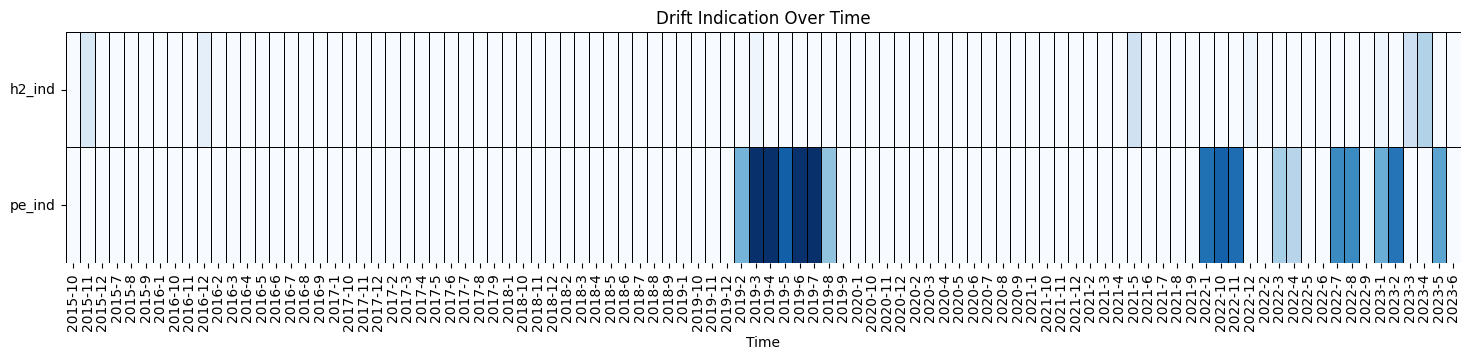

In [82]:
# Set the 'time' column as the index
# res.set_index('time', inplace = True)
import seaborn as sns
# df.set_index('time', inplace=True)

# Only keep the 'h2_ind' and 'pe_ind' columns for plotting
res_plot = res[['h2_ind', 'pe_ind']].T

plt.figure(figsize=(18, 3))
sns.heatmap(res_plot, cmap='Blues', cbar=False, linewidths=0.5, linecolor='black')

# Customizing the plot
plt.xlabel('Time')
plt.title('Drift Indication Over Time')
plt.yticks(rotation=0)
plt.show()